# Subclustering HPC neuron types to annotate CA2 subtype

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
from matplotlib import rcParams
import seaborn as sns

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### Outline

1. Loading Visium data and single cell reference
2. Show UMAP of cells and locations
3. cell2location analysis in one step
4. Automatic discrete region identification by clustering cell densities
5. Visualize cell type density gradients using diffusion maps

## 1. Loading Visium data and single cell reference

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [3]:
sp_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/viseum_cortex_trial/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/data/mouse_viseum_snrna/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_proj/notebooks/results/mouse_viseum_snrna/'

sample_data = pd.read_csv(sp_data_folder + 'Visum_mouse.csv')

In [4]:
sample_data

,sample_name,sample_name2,image_name,slide,position
0,ST8059048,Visium-28C,mouse_brain_he_Library_028_C05717_020_C1_14460...,C05717-020,C1
1,ST8059049,Visium-28D,mouse_brain_he_Library_028_C05717_020_D1_14460...,C05717-020,D1
2,ST8059050,Visium-28E,mouse_brain_he_Library_028_C05717_020_E1_14460...,C05717-020,E1
3,ST8059051,Visium-29B,mouse_brain_he_Library_029_C05717_021_B1_14460...,C05717-021,B1
4,ST8059052,Visium-29C,mouse_brain_he_Library_029_C05717_021_C1_14460...,C05717-021,C1


In [5]:
sc.logging.print_versions()

-----
anndata     0.7.4
scanpy      1.6.0
sinfo       0.3.1
-----
anndata             0.7.4
arviz               0.8.3
backcall            0.2.0
cairo               1.19.1
cell2location       NA
cffi                1.14.0
cftime              1.1.3
cutils_ext          NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
descartes           NA
fastprogress        0.2.3
get_version         2.1
h5py                2.10.0
igraph              0.8.2
importlib_metadata  1.7.0
ipykernel           5.3.0
ipython_genutils    0.2.0
ipywidgets          7.5.1
jedi                0.17.1
joblib              0.16.0
kiwisolver          1.2.0
lazylinker_ext      NA
legacy_api_wrap     0.0.0
leidenalg           0.8.0
llvmlite            0.32.1
louvain             0.6.1
mako                1.1.0
markupsafe          1.1.1
matplotlib          3.2.2
mizani              0.7.1
mkl                 2.3.0
mpl_toolkits        NA
natsort             7.0.1
netCDF4    

In [11]:
## snRNA reference (raw counts)
adata_snrna_raw = anndata.read_h5ad(sc_data_folder + "rawdata/all_cells_20200625.h5ad")

## Cell type annotations
labels = pd.read_csv(results_folder + 'snRNA_annotation_astro_subtypes_refined61_20200807.csv', index_col=0)

Add cell type labels as columns in `adata.obs`

In [14]:
labels = labels.reindex(index=adata_snrna_raw.obs_names)
adata_snrna_raw.obs[labels.columns] = labels
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['annotation_1'].isna(), :]

## Subcluster HPC

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
... storing 'annotation_1' as categorical


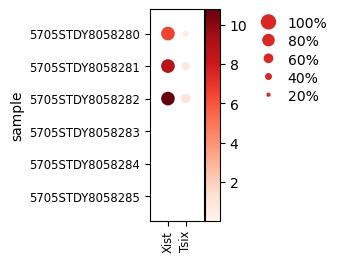

(2442, 10552)


Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


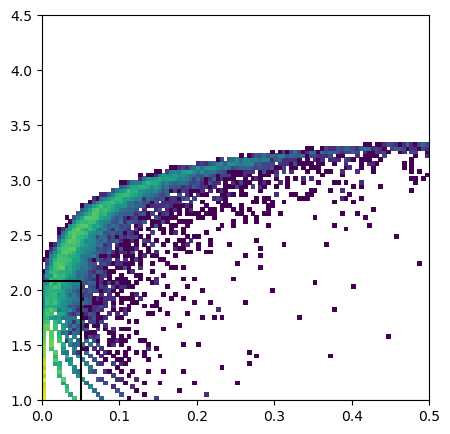

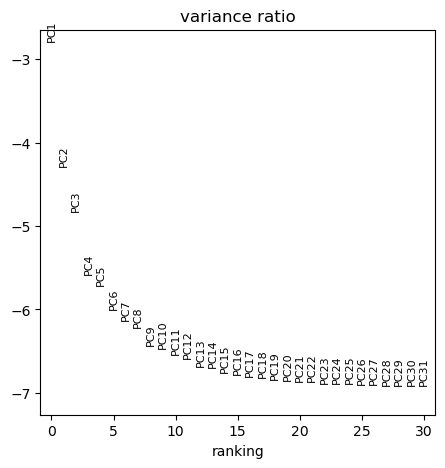

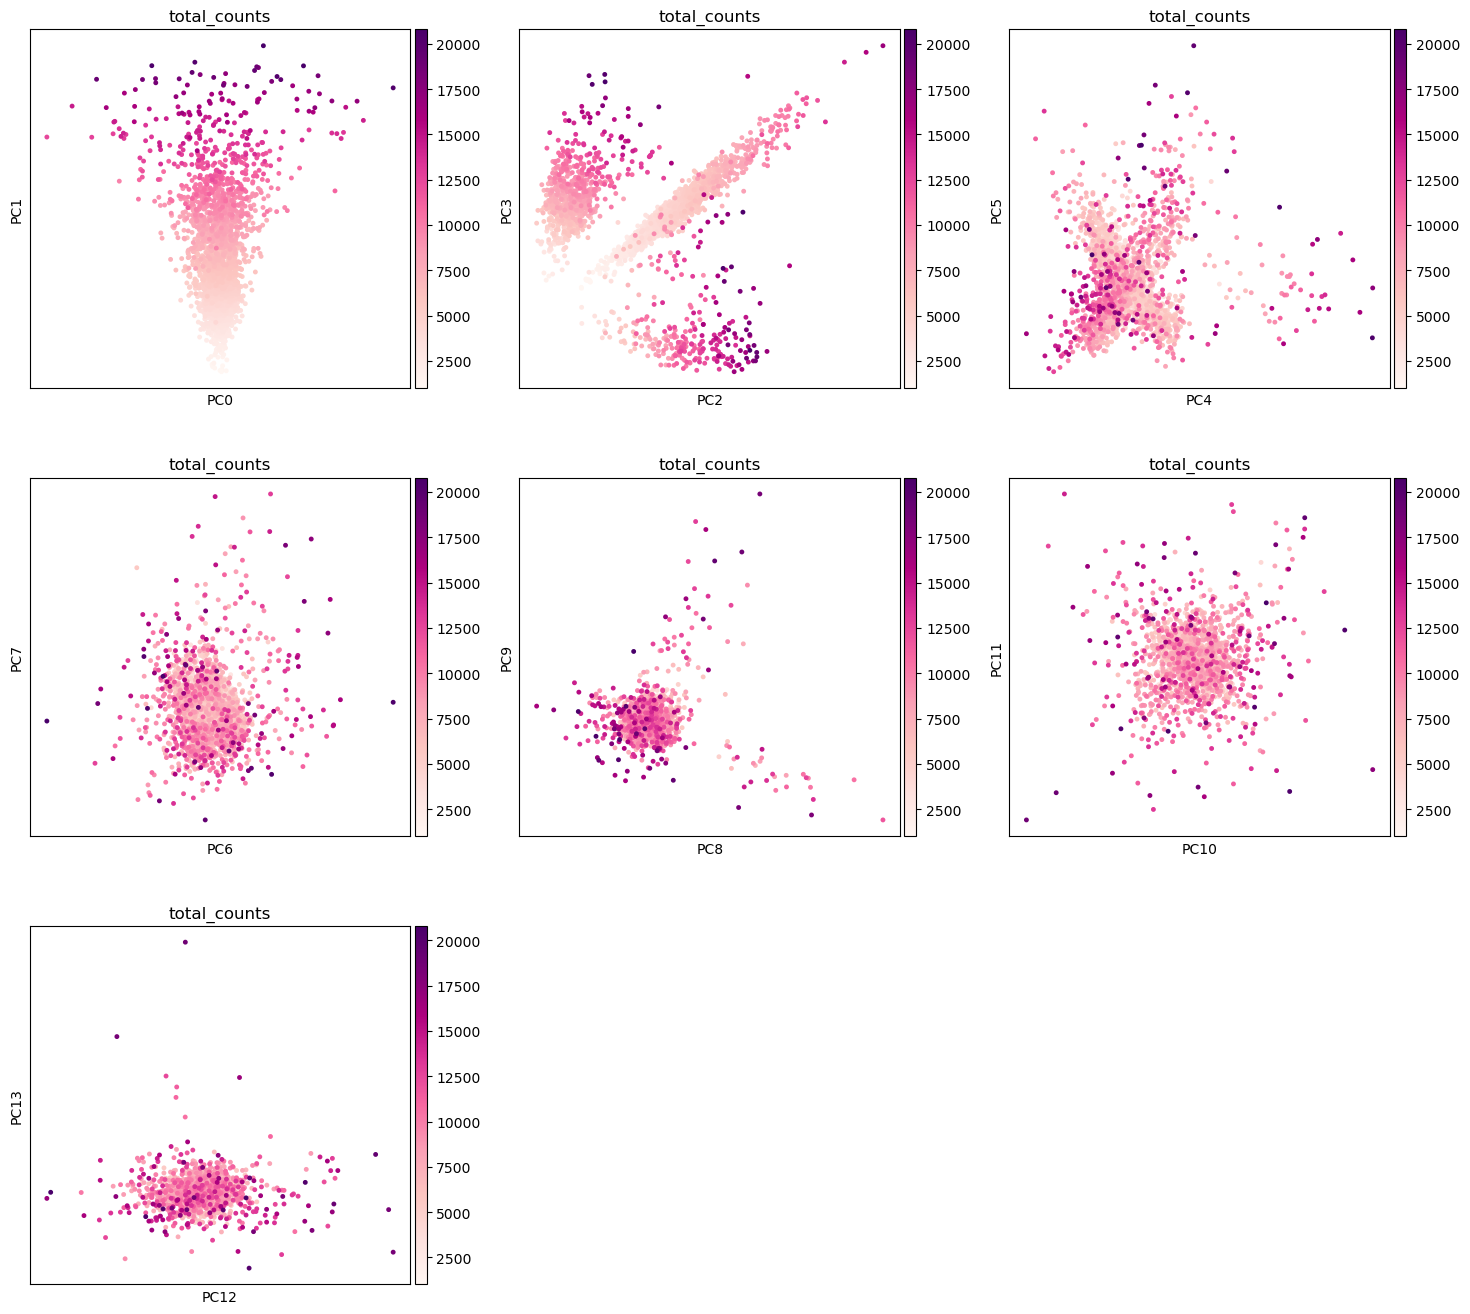

5705STDY8058285    744
5705STDY8058281    594
5705STDY8058280    574
5705STDY8058282    198
5705STDY8058284    178
5705STDY8058283    154
Name: sample, dtype: int64


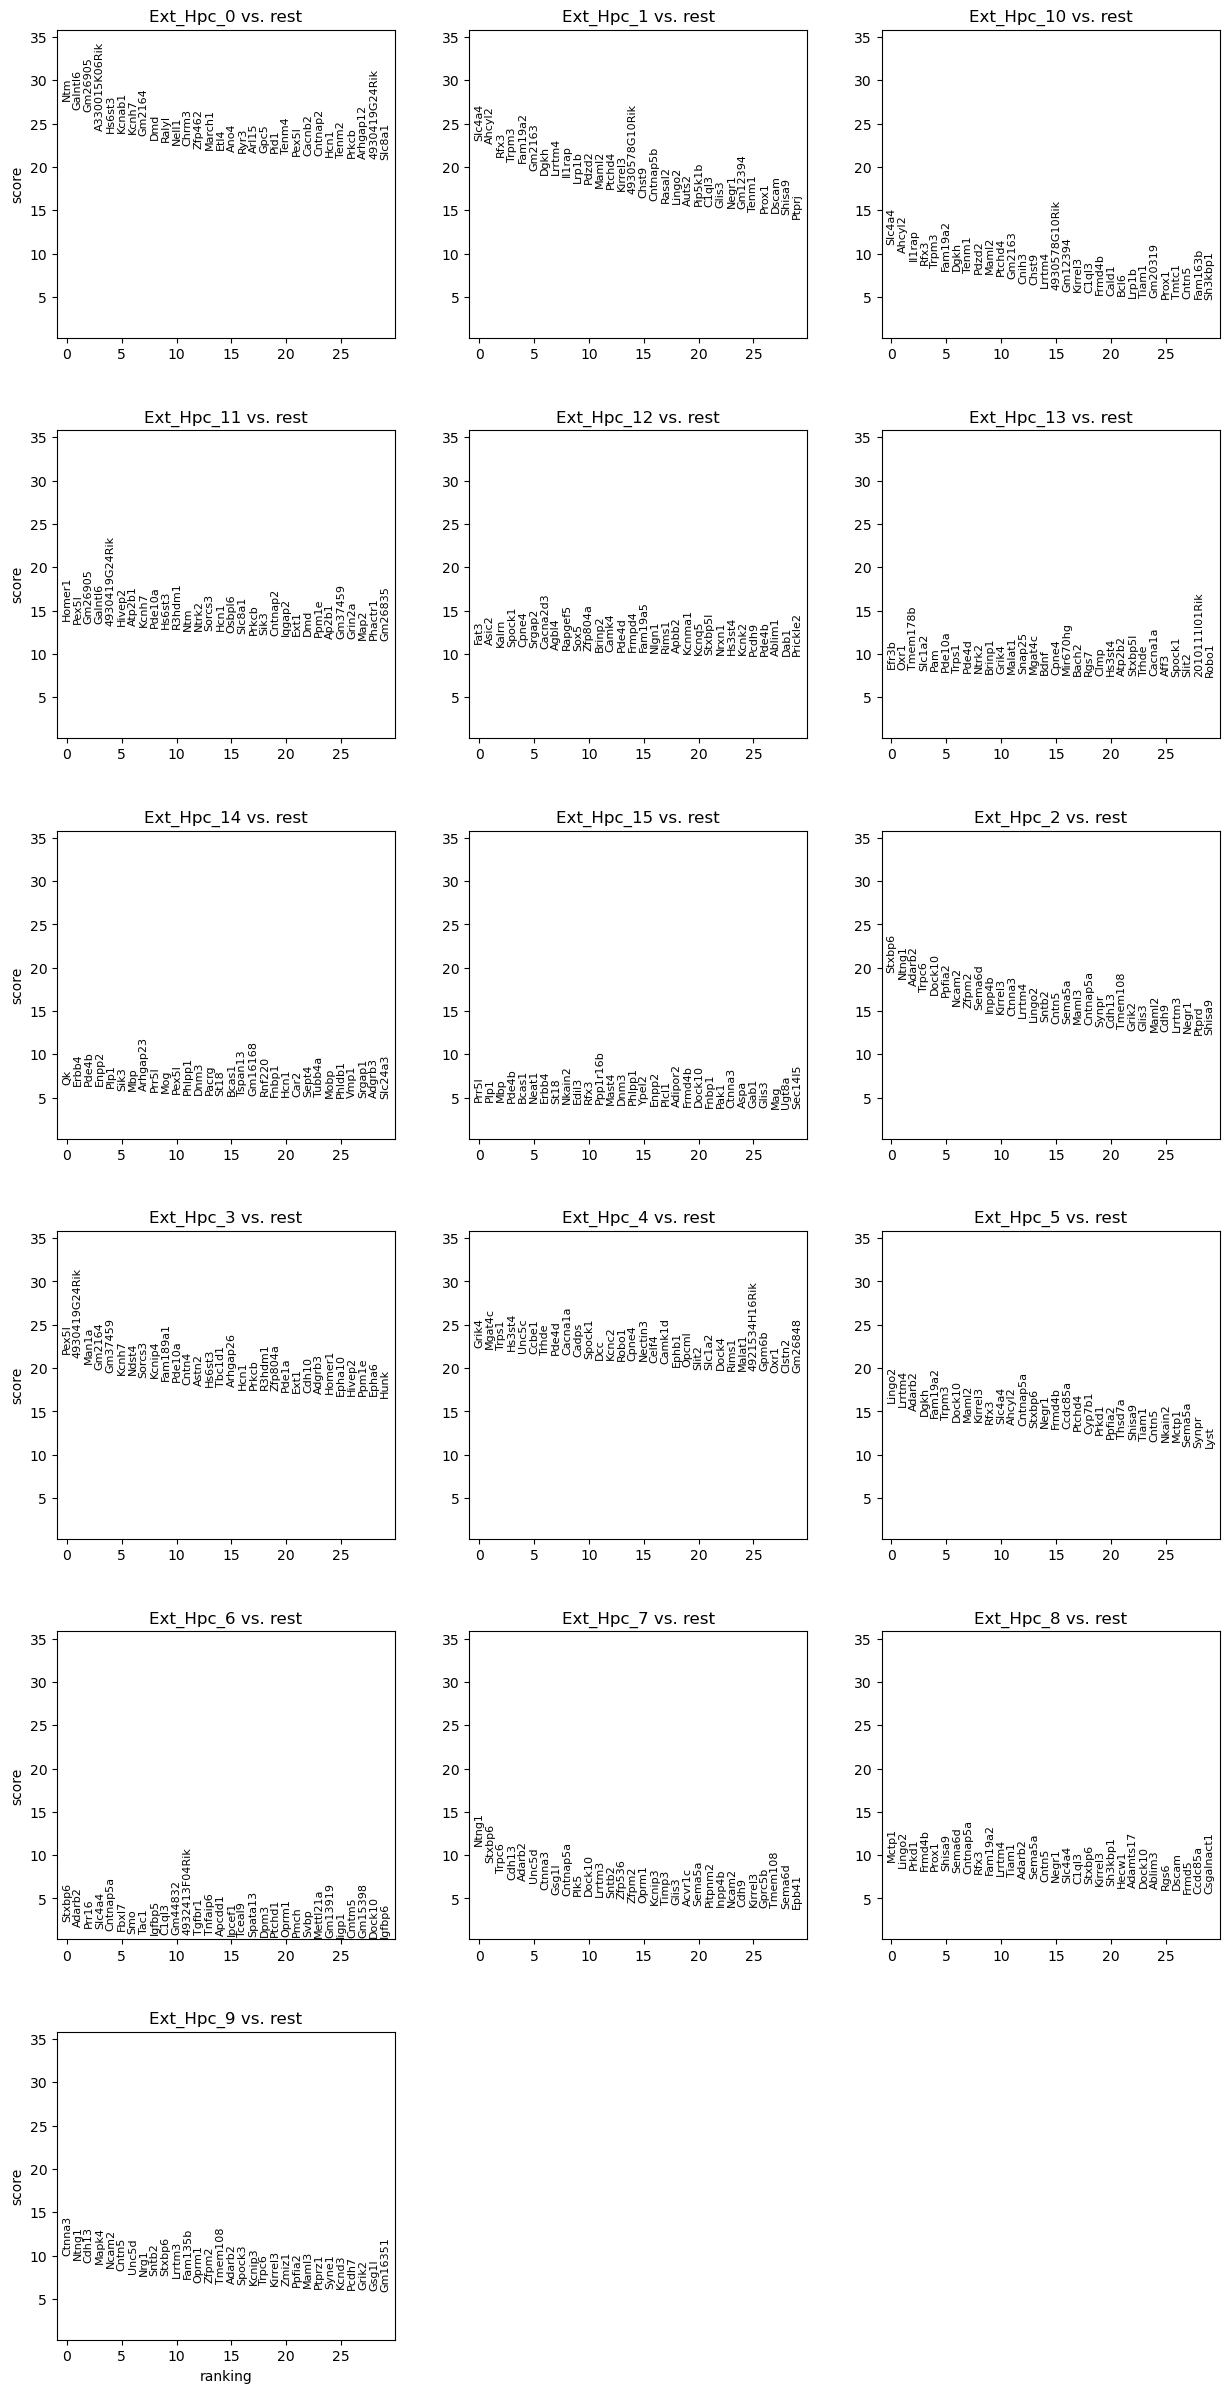

         Falling back to preprocessing with `sc.pp.pca` and default params.


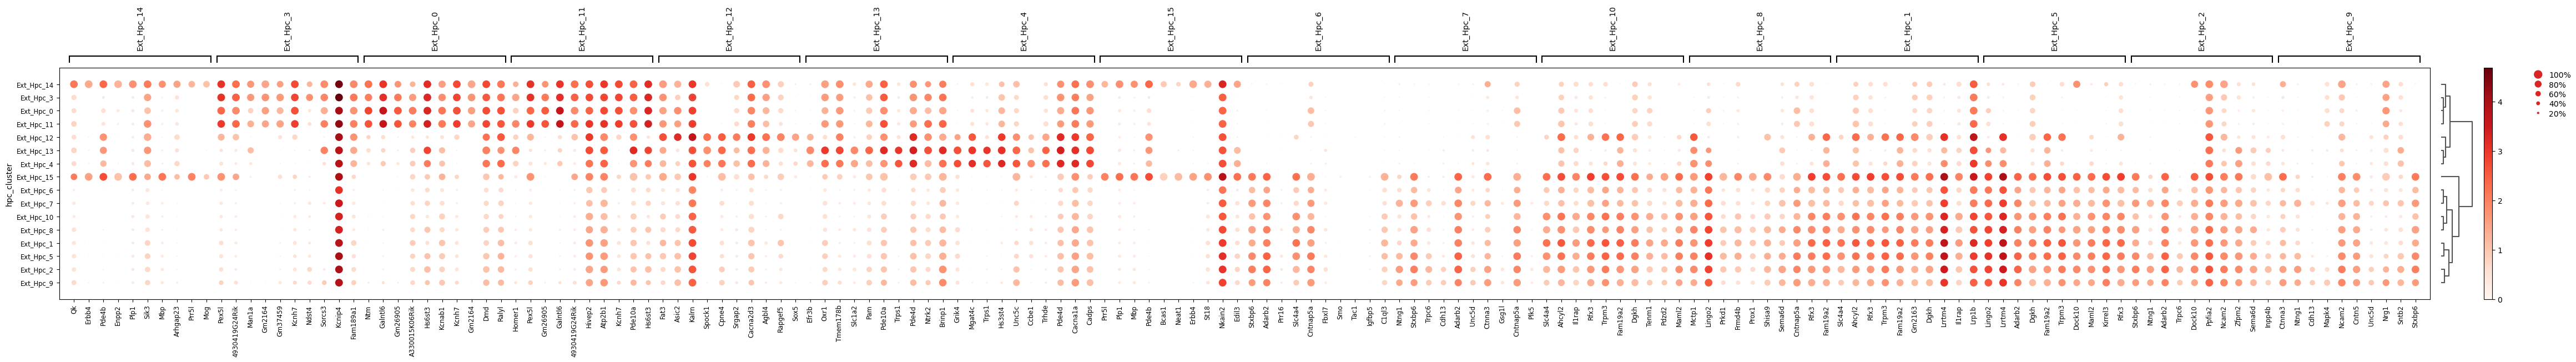

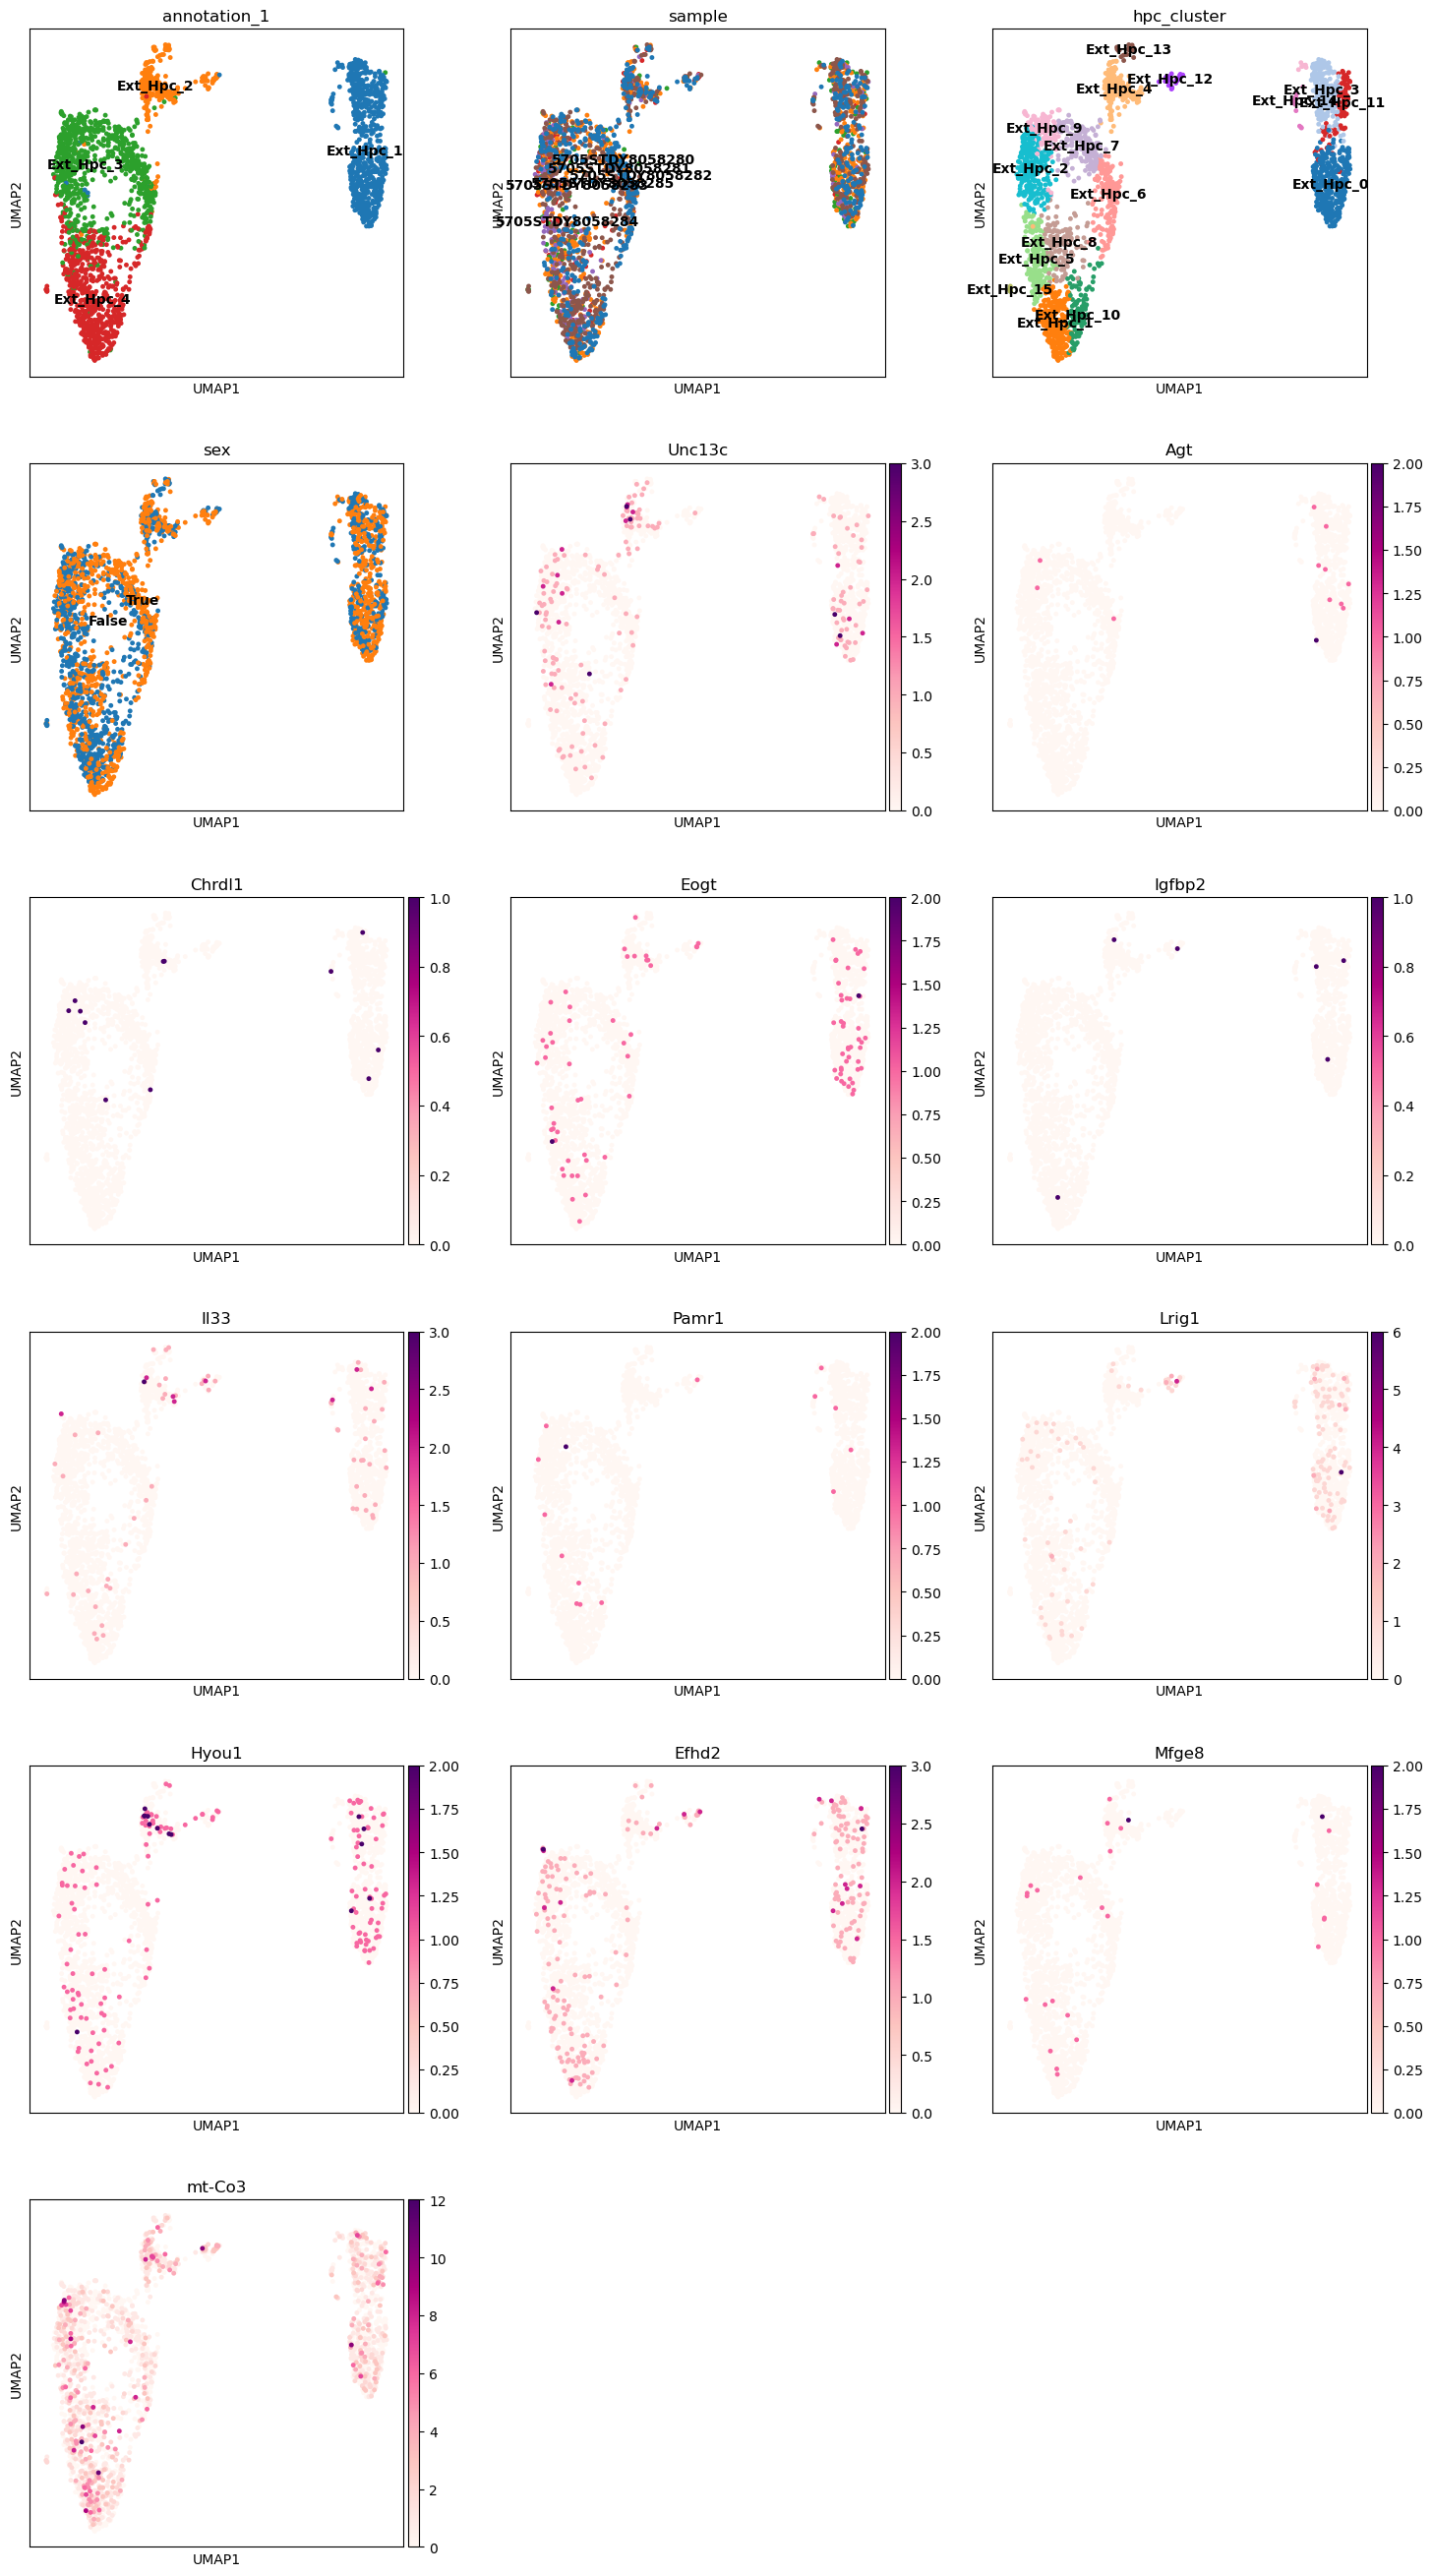

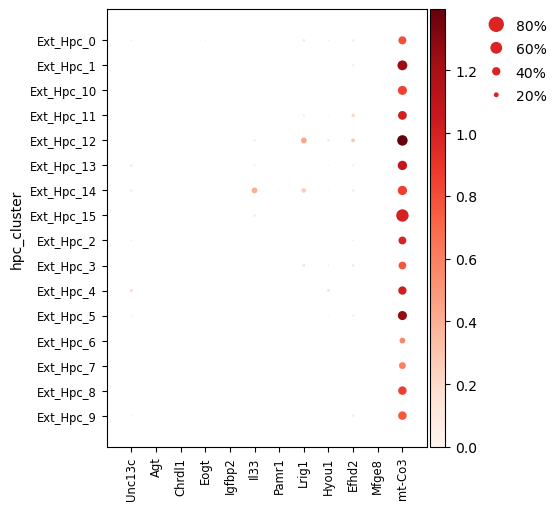

Ext_Hpc_0     355
Ext_Hpc_1     281
Ext_Hpc_2     273
Ext_Hpc_3     217
Ext_Hpc_4     206
Ext_Hpc_5     189
Ext_Hpc_6     184
Ext_Hpc_7     174
Ext_Hpc_8     131
Ext_Hpc_9     120
Ext_Hpc_10    117
Ext_Hpc_11     99
Ext_Hpc_12     48
Ext_Hpc_13     26
Ext_Hpc_14     15
Ext_Hpc_15      7
Name: hpc_cluster, dtype: int64


annotation_subclusters,Ext_Unknown_1,Ext_Unknown_3,Ext_Unknown_6,Ext_Unknown_7
hpc_cluster,,,,
Ext_Hpc_0,241,0,0,0
Ext_Hpc_1,0,0,1,109
Ext_Hpc_10,0,0,2,58
Ext_Hpc_11,64,0,1,0
Ext_Hpc_12,0,27,0,0
Ext_Hpc_13,0,11,0,0
Ext_Hpc_14,7,0,0,0
Ext_Hpc_15,0,0,0,3
Ext_Hpc_2,0,0,130,0


In [86]:
## snRNA reference (raw counts)
hpc = anndata.read_h5ad(sc_data_folder + "rawdata/all_cells_20200625.h5ad")

hpc.obs['sex'] = [s in ['5705STDY8058281', '5705STDY8058280', '5705STDY8058282'] 
                    for s in hpc.obs['sample']]
hpc.obs['sex'] = hpc.obs['sex'].astype('category')

## Cell type annotations
labels = pd.read_csv(results_folder + 'snRNA_annotation_astro_subtypes_refined61_20200807.csv', index_col=0)

hpc = hpc[labels.index,]
hpc.obs[labels.columns] = labels

# select HPC types
hpc_ind = labels.index[labels['annotation_1'].isin(['Ext_Hpc_1', 'Ext_Hpc_2', 'Ext_Hpc_3', 'Ext_Hpc_4'])]
hpc = hpc[hpc_ind,:]

sc.pl.dotplot(hpc, ['Xist', 'Tsix'], groupby='sample', gene_symbols='SYMBOL');

#########################
# keep raw data
hpc_raw = hpc.copy()

# Select cells
#min_genes = 1000  
rcParams["axes.facecolor"] = "white"

sc.pp.filter_cells(hpc, min_genes=1)
sc.pp.filter_genes(hpc, min_cells=1)

# calculate the mean of each gene across non-zero cells
hpc.var['n_cells'] = (hpc.X.toarray() > 0).sum(0)
hpc.var['nonz_mean'] = hpc.X.toarray().sum(0) / hpc.var['n_cells']

plt.hist2d(np.log10(hpc.var['nonz_mean']),
           np.log10(hpc.var['n_cells']), bins=100,
           norm=matplotlib.colors.LogNorm(),
           range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(hpc.shape[0] * 0.004)
cell_count_cutoff2 = np.log10(hpc.shape[0] * 0.05)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2);
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1);
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff);

print(hpc[:,(np.array(np.log10(hpc.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(hpc.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(hpc.var['n_cells']) > cell_count_cutoff)].shape)

# select genes based on mean expression in non-zero cells
hpc = hpc[:,(np.array(np.log10(hpc.var['nonz_mean']) > nonz_mean_cutoff)
         | np.array(np.log10(hpc.var['n_cells']) > cell_count_cutoff2))
      & np.array(np.log10(hpc.var['n_cells']) > cell_count_cutoff)
              & np.array(~hpc.var['SYMBOL'].isna())]

hpc.raw = hpc
#########################

#sc.pp.regress_out(hpc, ['sex'])

sc.pp.log1p(hpc)

# Find highly variable genes within each sample
hpc.var['highly_variable'] = False
for s in hpc.obs['sample'].unique():
    
    hpc_1 = hpc[hpc.obs['sample'].isin([s]), :]
    sc.pp.highly_variable_genes(hpc_1, min_mean=0.0012, max_mean=10, min_disp=0.3, n_top_genes=1000)
    
    hvg_list = list(hpc_1.var_names[hpc_1.var['highly_variable']])
    hpc.var.loc[hvg_list, 'highly_variable'] = True
    
#sc.pl.highly_variable_genes(hpc)

sc.pp.scale(hpc, max_value=10)
sc.tl.pca(hpc, svd_solver='arpack', n_comps=70, use_highly_variable=False)
sc.pl.pca_variance_ratio(hpc, log=True)
sc.pl.pca(hpc, color=['total_counts'],
          components=['0,1', '2,3', '4,5', '6,7', '8,9', '10,11', '12,13'],
          color_map = 'RdPu', ncols = 3, legend_loc='on data',
          legend_fontsize=10, gene_symbols='SYMBOL')
#hpc.obsm['X_pca'] = hpc.obsm['X_pca'][:, list(range(0, 3)) + list(range(4, hpc.obsm['X_pca'].shape[1]))]
#hpc.varm['PCs'] = hpc.varm['PCs'][:, list(range(0, 3)) + list(range(4, hpc.obsm['X_pca'].shape[1]))]
#hpc.obsm['X_pca'] = hpc.obsm['X_pca'][:, 1:]
#hpc.varm['PCs'] = hpc.varm['PCs'][:, 1:]
hpc.obsm['X_pca'] = hpc.obsm['X_pca'][:, 1:]
hpc.varm['PCs'] = hpc.varm['PCs'][:, 1:]
#########################

#sc.pp.neighbors(hpc, n_neighbors = 10, n_pcs = 10, metric='cosine')

import bbknn
bbknn.bbknn(hpc, neighbors_within_batch = 3, batch_key = 'sample', n_pcs = 30)
sc.tl.umap(hpc, min_dist = 0.2, spread = 0.8)

print(hpc.obs['sample'].value_counts())

#########################

sc.tl.leiden(hpc, resolution=2)

#########################
hpc_raw.obs['hpc_cluster'] = hpc.obs['leiden']
hpc_raw.obs['hpc_cluster'] = [f'Ext_Hpc_{i}' for i in hpc_raw.obs['hpc_cluster']]
hpc_raw.obs['hpc_cluster'] = hpc_raw.obs['hpc_cluster'].astype('category')
hpc_raw_sel = hpc_raw.copy()
sc.tl.rank_genes_groups(hpc_raw_sel, 'hpc_cluster', method='wilcoxon')
sc.pl.rank_genes_groups(hpc_raw_sel, gene_symbols='SYMBOL', n_genes=30, ncols=3)

hpc_raw_sel.var_names = hpc_raw_sel.var['SYMBOL']
hpc_raw_sel.raw = hpc_raw_sel

sc.pp.log1p(hpc_raw_sel)
sc.tl.rank_genes_groups(hpc_raw_sel, 'hpc_cluster', method='wilcoxon',
                        #groups=[f'Astro_{i}' for i in range(11)],
                        use_raw=False)

sc.pl.rank_genes_groups_dotplot(hpc_raw_sel, n_genes=10, use_raw=False)

sub_labels['hpc_cluster'] = hpc_raw.obs['hpc_cluster'].reindex(index=sub_labels.index)

#########################
hpc_raw.obsm['X_umap'] = hpc.obsm['X_umap']
hpc_raw.obsm['X_pca'] = hpc.obsm['X_pca']
hpc_markers = ['Unc13c', 'Agt', 
                 'Chrdl1', 'Eogt', 'Igfbp2',
                 'Il33', 'Pamr1', 'Lrig1', 'Hyou1',
                 'Efhd2','Mfge8', 'mt-Co3']

rcParams['figure.figsize'] = 5, 5
rcParams["axes.facecolor"] = "white"
sc.pl.umap(hpc_raw, color=['annotation_1', 'sample', 'hpc_cluster', 'sex'] + hpc_markers,
           color_map = 'RdPu', ncols = 3, legend_loc='on data',
           legend_fontsize=10, gene_symbols='SYMBOL')
sc.pl.dotplot(hpc_raw, hpc_markers, groupby='hpc_cluster', gene_symbols='SYMBOL');


#########################

print(hpc_raw.obs['hpc_cluster'].value_counts())
pd.crosstab(sub_labels['hpc_cluster'], sub_labels['annotation_subclusters'])

In [88]:
adata_snrna_raw.obs['hpc_cluster'] = hpc_raw.obs['hpc_cluster'].reindex(index=adata_snrna_raw.obs_names)
adata_snrna_raw.obs['annotation_1'] = adata_snrna_raw.obs['annotation_1'].astype(str)
adata_snrna_raw.obs['annotation_1'][~adata_snrna_raw.obs['hpc_cluster'].isna().values] = \
    adata_snrna_raw.obs['hpc_cluster'][~adata_snrna_raw.obs['hpc_cluster'].isna().values]

adata_snrna_raw.obs['annotation_1'].to_csv(f'{results_folder}snRNA_annotation_ext_hpc_subtypes{len(hpc_raw.obs["hpc_cluster"].unique())}_no_cov_bbknn_20200806.csv')

f'{results_folder}snRNA_annotation_ext_hpc_subtypes{len(hpc_raw.obs["hpc_cluster"].unique())}_no_cov_bbknn_20200806.csv'

'/nfs/team205/vk7/sanger_projects/cell2location_dev/notebooks/results/mouse_viseum_snrna/snRNA_annotation_ext_hpc_subtypes16_no_cov_bbknn_20200806.csv'

In [ ]:
reg_mod_name = 'RegressionNBV2Torch_77covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')

In [66]:
# remove likely doublet clusters
adata_snrna_raw = adata_snrna_raw[~adata_snrna_raw.obs['annotation_1'].isin(['Ext_Hpc_14', 'Ext_Hpc_15']),:]

# New annotation
adata_snrna_raw.obs['annotation_1_old'] = adata_snrna_raw.obs['annotation_1'].copy()
adata_snrna_raw.obs['annotation_1'] = adata_snrna_raw.obs['annotation_1'].astype(str)

adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Ext_Hpc_0', 'Ext_Hpc_11', 'Ext_Hpc_3'])] = \
'Ext_Hpc_CA1'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Ext_Hpc_12'])] = \
'Ext_Hpc_CA2'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Ext_Hpc_13', 'Ext_Hpc_4'])] = \
'Ext_Hpc_CA3'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Ext_Hpc_1', 'Ext_Hpc_2'])] = \
'Ext_Hpc_DG1'
adata_snrna_raw.obs['annotation_1'][adata_snrna_raw.obs['annotation_1'].isin(['Ext_Hpc_10', 'Ext_Hpc_5', 'Ext_Hpc_6', 'Ext_Hpc_7', 'Ext_Hpc_8', 'Ext_Hpc_9'])] = \
'Ext_Hpc_DG2'

In [67]:
adata_snrna_raw.obs['annotation_1'].to_csv(f'{results_folder}snRNA_annotation_hpc_subtypes_refined{len(adata_snrna_raw.obs["annotation_1"].unique())}_20200810.csv')
f'{results_folder}snRNA_annotation_hpc_subtypes_refined{len(adata_snrna_raw.obs["annotation_1"].unique())}_20200810.csv'

'/nfs/team205/vk7/sanger_projects/cell2location_dev/notebooks/results/mouse_viseum_snrna/snRNA_annotation_hpc_subtypes_refined62_20200810.csv'

Modules and their versions used for this analysis

In [ ]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass